In [148]:
import base64
import json
import numpy as np
from pyspark.mllib.clustering import KMeans
from __future__ import division
import matplotlib.pyplot as plt
import string
import operator
from time import time
import requests
%matplotlib inline

tweets = sc.textFile("tweets.json").map(json.loads)
tweets.take(1)

[{u'id': 1,
  u'label': u'0',
  u'text': u'is so sad for my APL friend.............'}]

In [2]:
# word processor...
def splitter(x):
    x = x.replace('.', ' ')
    x = x.replace(':)', ' :) ')
    x = x.replace(':(', ' :( ')
    x = x.replace('!', ' ! ')
    x = x.replace('?', ' ? ')
    x = string.lower(x)
    return x.split(' ')

# counts occurences of words within a tweet
def count(x):
    d = {}
    x = splitter(x['text'])
    for w in x:
        if d.has_key(w):
            d[w] += 1
        else:
            d[w] = 1
    return d

# reducer; merges two dictionaries of word frequencies
def dictMerge(x, y):
    d = x
    for word in d:
        if y.has_key(word):
            x[word] += y[word]
            del y[word]
    for word in y:
        d[word] = y[word]
    return d

In [3]:
# use 5% of tweets to form dictionary
tweets_d = tweets.sample(False, 0.05, seed = 100)
tweets_d = tweets_d.map(count).reduce(dictMerge)

In [4]:
# choose dSize most frequent words
dSize = 2000
dictionary = dict(sorted(tweets_d.items(), key = operator.itemgetter(1), reverse = True)[:dSize])

In [5]:
# 10 most common and least common words in our dictionary
sorted(dictionary.items(), key = operator.itemgetter(1), reverse = True)[:10]

[(u'', 182475),
 (u'!', 45394),
 (u'i', 36730),
 (u'to', 27601),
 (u'the', 25742),
 (u'a', 18573),
 (u'"', 15800),
 (u'my', 15207),
 (u'and', 14797),
 (u'you', 13119)]

In [6]:
sorted(dictionary.items(), key = operator.itemgetter(1), reverse = False)[:10]

[(u'direct', 40),
 (u'mo', 40),
 (u'weekend,', 40),
 (u'lookin', 40),
 (u'several', 40),
 (u'impossible', 40),
 (u'west', 40),
 (u'2nite', 40),
 (u'neither', 40),
 (u'limit', 40)]

In [7]:
del dictionary[''] # the space is pretty much useless
dictionary = [x[0] for x in sorted(dictionary.items(), key = operator.itemgetter(1), reverse = True)] # now we only need the words

In [25]:
enum = range(len(dictionary))

# map job to generate features
def feature_mapper(x):
    txt = splitter(x['text'])
    words = []
    for ind in enum:
        if dictionary[ind] in txt:
            words.append(ind)
    lab = x['label'] # want to convert this to integers 0, 1 or -1 for unknown
    try:
        lab = int(lab)
    except:
        lab = -1
    return (x['id'], (lab, len(txt), words))

tweets_featured = tweets.map(feature_mapper)
#tweets_featured = tweets_featured.sortByKey() # housekeeping to make lookup fast

In [26]:
tweets_featured.take(3)

[(1, (0, 20, [6, 11, 13, 17, 109, 282])),
 (2, (0, 9, [1, 3, 71, 255, 812, 1153])),
 (3, (0, 5, [68, 196, 254, 1056]))]

In [28]:
tweetList = tweets_featured.collect() # patient!

In [108]:
# get a unlabelled list
unlabelledList = []
for t in tweetList:
    if t[1][0] == -1:
        unlabelledList.append(t)
print 'Number of tweets with unknown labels: %d' % len(unlabelledList)

Number of tweets with unknown labels: 157638


In [286]:
# function to specify learning rate
def get_eta(const = 1, form = "const", t = None):
    assert form in ("const", "inv", "root")
    if form == "const":
        return const
    assert t != None
    if form == "root":
        return const / (t ** 0.5)
    return const / t

# returns a string giving the form of learning rate
def express_eta(const = 1, form = "const"):
    assert form in ("const", "inv", "root")
    if form == "const":
        return str(const)
    if form == "root":
        return "%s / root(t)" % const
    return "%s / t" % const

# predict probability pi (prob = True) or label for a tweet, with model parameters (b, beta)
# takes in a list of indices, indicating the active coefficients in beta
def predict(words, b, beta, prob = False):
    exponent = -b
    for w in words:
        exponent -= beta[w]
    #exponent -= beta_extra[0] * l
    pi = 1 / (1 + np.exp(exponent))
    if prob:
        return pi # probability
    return int(round(pi)) # predicted label

# function to train logistic regression using SGD
# dat: data entry
# d: dictionary
# etaForm: learning rate to use; see function get_eta
# reg: l^2 regularization penalty
# nPasses: number of times to cycle through training set
def trainSGD(dat, d, etaForm, reg, nPasses):
    start = time() # timer
    n = len(dat)
    beta = np.array([0] * len(d), dtype = np.float) # initiate beta for dictionary words
    #beta = [0] * len(d)
    #beta_extra = [0] * 1 # for other features
    b = 0 # intercept
    nErrors = 0 # cumulative error count
    errorRates = [] # cumulative error rates, evaluated per 1,000 tweets
    counter = 1
    counterUnlabelled = 0
    fpError = None # error rate on first pass
    
    for p in range(nPasses):
        for tweet in dat:
            lab, l, words = tweet[1] # unpack
            pi = predict(words, b, beta, True)
            pred = int(round(pi))

            if lab == -1: # make prediction if label is unknown
                lab = pred
                counterUnlabelled += 1
            if lab != pred:
                nErrors += 1
            if counter % 1000 == 0:
                errorRates.append(nErrors / (counter - counterUnlabelled - 1))

            # update
            args = etaForm + (counter,) # arguments for the get_eta function
            eta = get_eta(*args)
            # first we apply regularization
            # we leave the intercept alone
            beta = beta * (1 - 2 * reg * eta)

            multiplier = eta * (lab - pi)
            b = b + multiplier
            #beta[words] += multiplier # surprisingly this is slower than the loop below
            for w in words:
                beta[w] = beta[w] + multiplier
            #beta_extra[0] = beta_extra[0] + multiplier * l
            counter += 1
        if not fpError:
            fpError = nErrors / (counter - counterUnlabelled - 1)
            
    return {'intercept' : b, 'beta' : beta, 'errors' : errorRates, 'total' : counter - 1, 'fpError' : fpError, 'time' : time() - start}

In [287]:
# try the aggresive learning rate 1/root(t)
passes = 5
fit = trainSGD(tweetList, dictionary, (1, "root"), 0.00005, passes)
# this regularization parameter leads to a L2 norm of ~93% of the unregularized

Error rate on unlabelled tweets (marked red): 22.68%
L2 norm of beta: 259.45


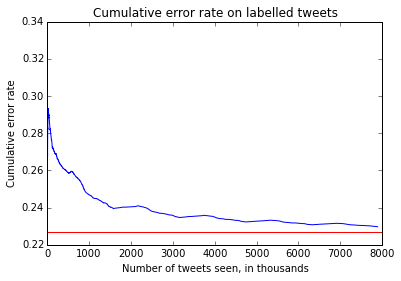

In [288]:
# function to compute error rate on unlabelled tweets
def getUnlabelledError(dat, b, beta):
    d = {}
    for t in dat:
        d[t[0]] = str(predict(t[1][2], b, beta))
    packed_results = "\n".join(["{0} {1}".format(key, value.strip()) for key, value in d.items()])
    got = requests.post("http://lsda.cs.uchicago.edu:5000", files={"results": packed_results}).json()
    return 1 - got['correct'] / got['of']

# take a look at the result
def evalFit(fit, prt = True):
    x_cord = range(1, len(fit['errors']) + 1)
    plt.plot(x_cord, fit['errors'])
    plt.xlabel("Number of tweets seen, in thousands")
    plt.ylabel("Cumulative error rate")
    plt.title("Cumulative error rate on labelled tweets")
    #print "Total examples trained: %d" % fit['total']
    #print "First pass error rate: %.2f%%" % (fit['fpError'] * 100)
    err = getUnlabelledError(unlabelledList, fit['intercept'], fit['beta'])
    if prt:
        print "Error rate on unlabelled tweets (marked red): %.2f%%" % (100 * err)
        print "L2 norm of beta: %.2f" % np.sum(fit['beta'] ** 2)
    plt.axhline(err, color = 'r') # red line indicating error rate on unlabelled tweets
evalFit(fit)

In [261]:
# some words with largest positive and negative coefficients
tuples = zip(dictionary, fit['beta'])
sorted(tuples, key = operator.itemgetter(1), reverse = True)[:10]

[(u'welcome', 1.521746607280543),
 (u'thanks', 1.498703344122011),
 (u'excited', 1.4136506583168553),
 (u'thank', 1.4084595481556899),
 (u'wait', 1.3669431674756138),
 (u'glad', 1.3622821619891203),
 (u'happy', 1.2826554383547204),
 (u'awesome', 1.2693826552656795),
 (u'yay', 1.2036242168039275),
 (u'smile', 1.1966137172694418)]

In [262]:
sorted(tuples, key = operator.itemgetter(1))[:10]

[(u'sad', -3.1508477427732449),
 (u'sucks', -2.4042725509178084),
 (u'poor', -2.3665990796658054),
 (u'miss', -2.3383228631079036),
 (u'missing', -2.1269197603812016),
 (u'sick', -2.0330288971880832),
 (u'hurts', -1.823373842978899),
 (u'sorry', -1.7785914687573317),
 (u'hate', -1.7661141411753061),
 (u'lost', -1.7494841993582972)]

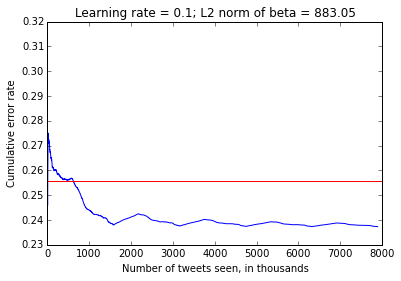

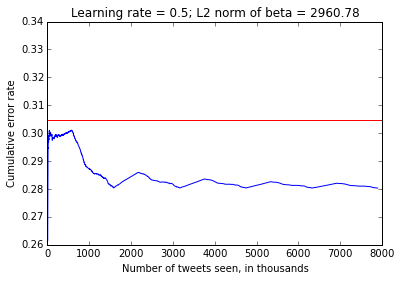

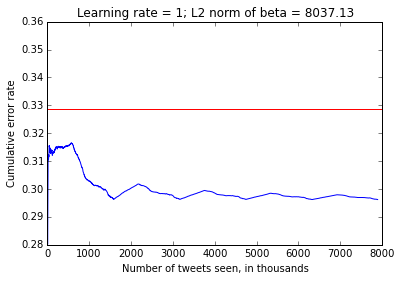

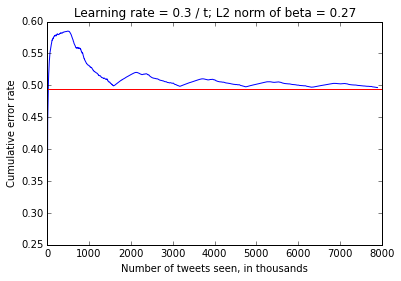

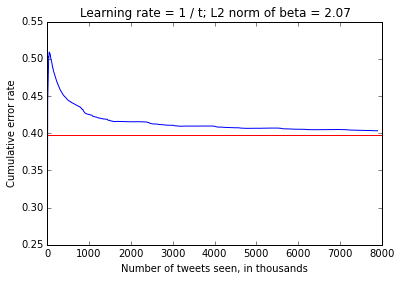

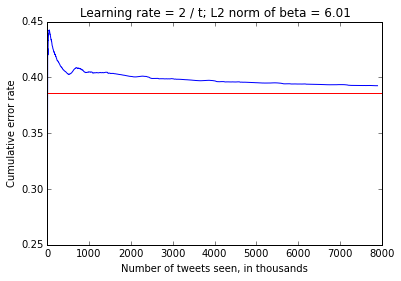

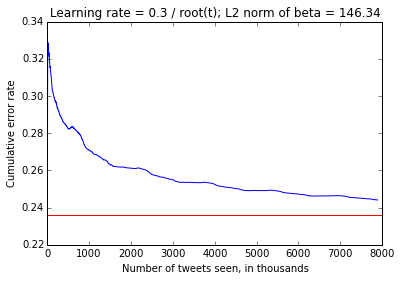

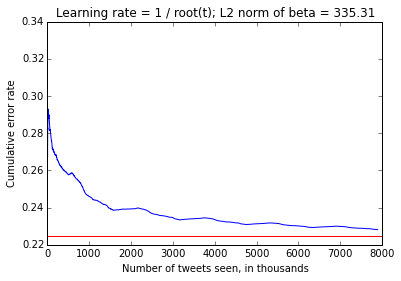

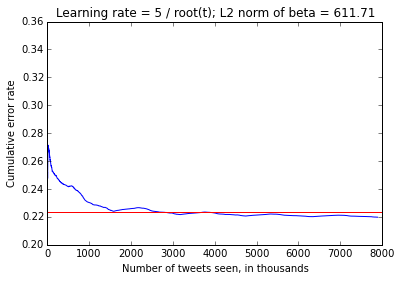

In [292]:
all_etas = [(0.1, "const"), (0.5, "const"), (1, "const"), (0.3, "inv"), (1, "inv"), (2, "inv"), (0.3, "root"), (1, "root"), (5, "root")]
l2penalty = 0.00001
passes = 5
for i in range(len(all_etas)):
    plt.figure(i)
    fit = trainSGD(tweetList, dictionary, all_etas[i], l2penalty, passes)
    evalFit(fit, prt = False)
    plt.title('Learning rate = %s; L2 norm of beta = %.2f' % (express_eta(*all_etas[i]), np.sum(fit['beta'] ** 2)))

In [ ]:
# Constant learning rate tends to overfit
# Conservative learning rate is too slow
# Aggresive learning rate seems to work well